In [0]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/HDFC Hackathon/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from xgboost import XGBClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
data = pd.read_csv('Train.csv', low_memory=False)
print(data.shape)
data.head()

(17521, 2395)


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,...,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,9.114586e+03,3.043078e+04,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,NaN,NaN,1.486524,1.728324,0.993441,1.297050,0.137398,0.115987,0.260428,1.414214,1,1,1,1,1,1,0,6,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,0,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,2.013518e+05,1.859404e+05,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,NaN,NaN,0.792123,0.934556,0.893203,0.966620,0.753892,0.808295,1.414214,NaN,1,1,3,4,4,0,4,5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,0,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,9.368338e+06,1.113330e+07,16.496090,16.749305,16.532874,16.128357,1.145182,2.203874,NaN,NaN,0.422264,0.498347,0.683582,0.735339,0.808115,0.776910,1.414214,NaN,3,3,4,12,4,0,2,4,NaN,1.0,NaN,NaN,...,1,0,1,0,1,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,0,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,4.304848e+05,4.065539e+05,13.419061,13.624018,13.541837,13.429097,1.204010,0.536304,NaN,NaN,0.437243,0.521341,0.623499,0.534531,-0.125829,0.388830,-1.414214,NaN,2,2,2,24,1,0,1,4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,2,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,0,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,3.473444e+06,3.262168e+06,NaN,14.764533,14.551021,NaN,NaN,NaN,NaN,NaN,NaN,1.344637,NaN,1.563430,-0.113101,0.617486,1.414214,NaN,4,3,4,68,8,0,2,4,NaN,3.0,NaN,NaN,...,0,0,0,0,0,0,2,1,0,0,0,0,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [0]:
data.describe()

,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,Col41,...,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
count,17521.000000,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,1.752100e+04,16272.000000,16277.000000,16275.000000,16278.000000,16051.000000,14661.000000,2762.000000,3202.000000,16280.000000,16277.000000,16278.000000,16275.000000,17521.000000,17521.000000,16839.000000,5261.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,1648.000000,486.000000,2257.000000,475.000000,1509.000000,...,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.00000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,16347.000000,16347.000000,16335.000000,16347.00000,16347.000000,16335.000000
mean,0.100508,3.158967e+04,2.046540e+04,2.502937e+04,2.789385e+04,2.597734e+04,3.302600e+04,2.912693e+04,2.971069e+04,3.617392e+04,3.553214e+04,9.303774,9.145233,9.380505,9.226015,1.077682,3.487721,37.651259,11.620315,1.017542,1.179720,0.760987,0.886490,0.191677,0.143002,0.286669,0.158979,1.438103,1.380115,1.467325,1.600765,1.412248,0.998059,0.089778,5.108099,7.666869,3.681070,3.985822,11.511579,3.566600,...,0.257634,0.161064,0.791051,0.529365,0.231322,0.145996,0.149421,0.108213,0.306261,0.233548,1.053650,0.90149,1.151133,0.929456,0.033503,0.041893,0.041550,0.026768,1.096284,0.909023,1.063238,0.901261,0.344786,0.270133,0.048684,0.028823,0.243023,0.198105,0.086468,0.059586,0.736202,0.595343,0.773757,0.639005,55.540038,55.015416,35.180961,17.99584,17.539977,10.359657
std,0.300685,7.612897e+05,7.136908e+05,6.018207e+05,6.091245e+05,7.211998e+05,7.488433e+05,2.175595e+05,2.981508e+05,2.612427e+05,2.706854e+05,1.709428,1.902826,1.905931,1.618022,0.151220,21.767014,317.363666,73.914269,0.645896,3.470841,0.481458,0.641438,0.318460,0.316152,0.560927,0.929660,0.697317,0.684984,0.768959,1.751652,0.787507,0.186278,0.301043,0.833285,12.241501,9.663788,1.911326,23.218131,12.483319,...,0.656329,0.485725,0.910368,0.733149,0.630533,0.466855,0.421105,0.339287,0.668032,0.541662,0.950173,0.88770,0.992776,0.868421,0.199218,0.219127,0.267509,0.190296,0.952303,0.875432,0.952943,0.885680,0.709208,0.585131,0.295270,0.195036,0.609345,0.511142,0.314962,0.251910,0.910828,0.784953,0.921805,0.806286,53.269618,52.697069,34.956016,24.83891,24.685954,18.476447
min,0.000000,-8.555719e+07,-8.555719e+07,-7.011955e+07,-7.100920e+07,-8.480658e+07,-9.016250e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.714798,-2.772589,-2.484911,-1.820159,0.005103,-1071.697234,-992.569191,-340.921462,0.000143,0.000000,0.000000,0.000000,-1.220481,-1.220485,-1.414214,-1.414214,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,2.742337e+03,2.007863e+03,1.857013e+03,2.562647

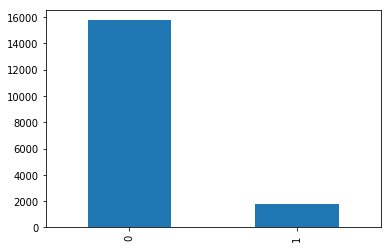

In [0]:
data.Col2.value_counts().plot(kind='bar');

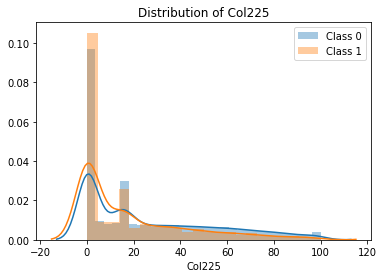

In [0]:
for i in data.columns[2:]:
    plt.title(f'Distribution of {i}')
    sns.distplot(data[data['Col2'] == 0][i], label='Class 0')
    sns.distplot(data[data['Col2'] == 1][i], label='Class 1')
    plt.legend()
    plt.show();
    # input("Press Enter to continue...")
    clear_output(wait=3)

In [0]:
cnt = 0
cols_to_remove = []
for i,j in zip(data.columns, data.isnull().sum()):
    missing_pct = round((j/data.shape[0]) * 100, 2)
    if missing_pct > 70:
        print(f'{i} {j} --> {missing_pct}% data missing.')
        cnt += 1
        cols_to_remove.append(i)
print(f'\n# of Columns with missing values greater than 70% --> {cnt}')

Col19 14759 --> 84.24% data missing.
Col20 14319 --> 81.72% data missing.
Col37 15873 --> 90.59% data missing.
Col38 17035 --> 97.23% data missing.
Col39 15264 --> 87.12% data missing.
Col40 17046 --> 97.29% data missing.
Col41 16012 --> 91.39% data missing.
Col99 13033 --> 74.39% data missing.
Col113 13092 --> 74.72% data missing.
Col138 13866 --> 79.14% data missing.
Col139 13866 --> 79.14% data missing.
Col140 13866 --> 79.14% data missing.
Col141 13866 --> 79.14% data missing.
Col142 13866 --> 79.14% data missing.
Col143 13866 --> 79.14% data missing.
Col144 13866 --> 79.14% data missing.
Col145 13866 --> 79.14% data missing.
Col146 13866 --> 79.14% data missing.
Col147 13866 --> 79.14% data missing.
Col148 13866 --> 79.14% data missing.
Col149 13914 --> 79.41% data missing.
Col150 13914 --> 79.41% data missing.
Col151 13914 --> 79.41% data missing.
Col152 13914 --> 79.41% data missing.
Col153 13914 --> 79.41% data missing.
Col154 13914 --> 79.41% data missing.
Col155 13914 --> 79.

In [0]:
data.drop(cols_to_remove, axis=1, inplace=True)
print(data.shape)
print(f'% of columns retained --> {round((data.shape[1]/2395) * 100, 2)}')

(17521, 2202)
% of columns retained --> 91.94


In [0]:
cols = defaultdict(list)
for i,j in zip(data.columns, data.dtypes):
    if i == 'Col1' or i == 'Col2':
        continue
    cols[str(j)].append(i)

print(cols.keys())

dict_keys(['float64', 'int64'])


In [0]:
len(cols['float64']), len(cols['int64'])

(653, 1547)

In [0]:
mode_cols = []
for i in cols['float64']:
    nulls = data[i].isnull().sum()
    uniques = data[i].nunique()
    if nulls > 0:
        if uniques < 400:
            mode_cols.append(i)
        # print(i, "===>", uniques, "===>", nulls)
print(f'# of Cols having null values and unique values < 400 ---> {len(mode_cols)}')

# of Cols having null values and unique values < 400 ---> 79


In [0]:
cnt = 0
for i in data.isnull().sum():
    if i > 0:
        cnt += 1
print(cnt)

for i in mode_cols:
    data[i].fillna(value=data[i].mode().iloc[0], inplace=True)
    # print(i, data[i].mode().iloc[0])

cnt = 0
for i in data.isnull().sum():
    if i > 0:
        cnt += 1
print(cnt)

566
487


In [0]:
data.fillna(value=data.median(), inplace=True)
for i,j in zip(data.columns, data.isnull().sum()):
    if j > 0:
        print(i,j)

In [0]:
data.Col1.nunique()

17521

[1.68149163e-01 6.22980591e-02 5.13507537e-02 ... 7.58873818e-34
 7.58873818e-34 4.55389526e-34]


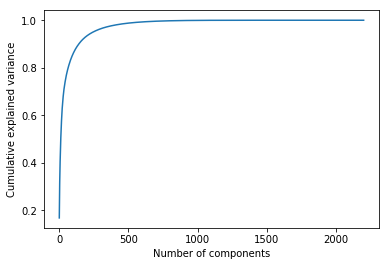

In [0]:
%%time
sc = StandardScaler()
X = sc.fit_transform(data.drop(['Col1', 'Col2'], axis=1))

pca = PCA(random_state=42)
pca.fit(X)
print(pca.explained_variance_ratio_)

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [0]:
for i,j in enumerate(pca.explained_variance_ratio_.cumsum()):
    if j > 0.90:
        print(i)
        break

141


In [0]:
X = StandardScaler().fit_transform(data.drop(['Col1', 'Col2'], axis=1))
# X = data.drop(['Col1', 'Col2'], axis=1)

pca = PCA(n_components=141, random_state=42)
X = pca.fit_transform(X)
y = data['Col2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# sampler = RandomOverSampler(random_state=42)
sampler = SMOTE(random_state=42)
print("Before Over Sampling -->\n", y_train.value_counts())
X_train, y_train = sampler.fit_sample(X_train, y_train)
print("After Over Sampling -->\n", pd.Series(y_train).value_counts())

sampler = RandomOverSampler(random_state=42)
print("Before Over Sampling -->\n", y_test.value_counts())
X_test, y_test = sampler.fit_sample(X_test, y_test)
print("After Over Sampling -->\n", pd.Series(y_test).value_counts())

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Before Over Sampling -->
 0    12607
1     1409
Name: Col2, dtype: int64
After Over Sampling -->
 1    12607
0    12607
dtype: int64
Before Over Sampling -->
 0    3153
1     352
Name: Col2, dtype: int64
After Over Sampling -->
 1    3153
0    3153
dtype: int64
(25214, 141) (6306, 141) (25214,) (6306,)


# Logistic Regression

In [0]:
%%time

params = {'fit_intercept':[True, False],
          'penalty':['l2', 'l1'],
          'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr = LogisticRegression(solver='saga', n_jobs=-1)
lr_model = RandomizedSearchCV(lr, param_distributions=params, n_iter=15, scoring='f1_macro', cv=4, verbose=True, random_state=42)
lr_model.fit(X_train, y_train)
y_hat = lr_model.predict(X_test)
# feat_imp = sorted(list(zip(X.columns, [abs(x) for x in lr_model.best_estimator_.coef_[0]])), key=lambda x: x[1], reverse=True)
# y_ax = [x for (x,_) in feat_imp[:20]]
# print(y_ax)

print()
print(lr_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, lr_model.predict(X_train)))
print("F1-Score (Test):", f1_score(y_test, y_hat))
print()
print("Classification Report:\n", classification_report(y_test, y_hat))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))

# print()
# plt.figure(figsize=(10,5))
# x_ax = [x for (_,x) in feat_imp[:20]]
# plt.title('Feature Importances')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# sns.barplot(x_ax, y_ax);

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.7min finished



LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

F1-Score (Train): 0.6834101755237402
F1-Score (Test): 0.6433774834437086

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.70      0.67      3153
           1       0.67      0.62      0.64      3153

    accuracy                           0.66      6306
   macro avg       0.66      0.66      0.66      6306
weighted avg       0.66      0.66      0.66      6306


Confusion Matrix:
 [[2209  944]
 [1210 1943]]
CPU times: user 7 s, sys: 6.91 s, total: 13.9 s
Wall time: 3min 44s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
top_cols = [x for (x,_) in feat_imp[:200]]
print(top_cols)

['Col875', 'Col933', 'Col874', 'Col877', 'Col34', 'Col28', 'Col60', 'Col85', 'Col77', 'Col912', 'Col876', 'Col13', 'Col24', 'Col30', 'Col645', 'Col603', 'Col88', 'Col135', 'Col611', 'Col932', 'Col67', 'Col604', 'Col931', 'Col437', 'Col620', 'Col649', 'Col2393', 'Col893', 'Col127', 'Col910', 'Col172', 'Col21', 'Col173', 'Col2006', 'Col306', 'Col29', 'Col621', 'Col240', 'Col390', 'Col69', 'Col2392', 'Col383', 'Col33', 'Col14', 'Col1129', 'Col652', 'Col586', 'Col23', 'Col697', 'Col257', 'Col15', 'Col51', 'Col657', 'Col440', 'Col776', 'Col936', 'Col612', 'Col59', 'Col608', 'Col177', 'Col636', 'Col1140', 'Col855', 'Col579', 'Col31', 'Col125', 'Col2166', 'Col54', 'Col861', 'Col633', 'Col193', 'Col133', 'Col605', 'Col1738', 'Col86', 'Col161', 'Col229', 'Col186', 'Col654', 'Col65', 'Col160', 'Col1848', 'Col1253', 'Col1761', 'Col1987', 'Col367', 'Col902', 'Col452', 'Col1273', 'Col2208', 'Col1276', 'Col1859', 'Col700', 'Col503', 'Col805', 'Col598', 'Col1711', 'Col256', 'Col2312', 'Col1999', 'Col

# XGBoost Classifier

In [0]:
%%time

parameters = {'max_depth': sp_randint(3, 25),
              'learning_rate': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
              'n_estimators': sp_randint(50, 125),
              'reg_alpha': [100, 10, 1, 0, 0.1, 0.01, 1e-4],
              'reg_lambda': [100, 10, 1, 0, 0.1, 0.01, 1e-4],
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'colsample_bylevel': sp_uniform(loc=0.4, scale=0.6),
              'colsample_bynode': sp_uniform(loc=0.4, scale=0.6),
             }

xgb = XGBClassifier(n_jobs=-1)
xgb_model = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=15, scoring='f1_macro', cv=3, refit=True, verbose=True, random_state=42)
xgb_model.fit(X_train, y_train)
y_hat = xgb_model.predict(X_test)
# feat_imp = sorted(list(zip(X.columns, model.best_estimator_.feature_importances_)), key=lambda x: x[1], reverse=True)
# y_ax = [x for (x,_) in feat_imp]
# print(y_ax)

print()
print(xgb_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, xgb_model.predict(X_train)))
print("F1-Score (Test):", f1_score(y_test, y_hat))
print()
print("Classification Report:\n", classification_report(y_test, y_hat))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))

# print()
# plt.figure(figsize=(10,5))
# x_ax = [x for (_,x) in feat_imp]
# plt.title('Feature Importances')
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# sns.barplot(x_ax, y_ax);

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  5.6min finished



XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8248435466776274,
              colsample_bynode=0.41235069657748147,
              colsample_bytree=0.9819459112971965, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=8, min_child_weight=0.001,
              missing=None, n_estimators=113, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6939852077021733, verbosity=1)

F1-Score (Train): 0.9673493270918665
F1-Score (Test): 0.1957547169811321

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      3153
           1       0.17      0.24      0.20       352

    accuracy                           0.81      3505
   macro avg       0.54      0.55      0.54      3505
weighted avg       0.84      0.81      0.82      3505


# LightGBM Classifier

In [0]:
%%time

d_train = lgb.Dataset(X_train, label=y_train)
# parameters = {'max_depth': sp_randint(3,25),
#               'learning_rate': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
#               'n_estimators': sp_randint(50,125),
#               'boosting_type': ['gbdt'],
#               'objective': ['binary'],
#               'metric': ['binary_logloss'],
#               'sub_feature': [0.3, 0.5, 0.7],
#               'num_leaves': sp_randint(3,25),
#               'min_data': sp_randint(25,75),
#              }
parameters = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500),
             'max_depth': sp_randint(3, 25),
             'n_estimators': sp_randint(50, 125),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

lgbc = lgb.LGBMClassifier(random_state=42, objective='binary', metric='binary_logloss', silent=True)
lgb_model = RandomizedSearchCV(estimator=lgbc, param_distributions=parameters, n_iter=15, scoring='f1_macro', cv=3, refit=True, random_state=42, verbose=True, n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

print()
print(lgb_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, lgb_model.predict(X_train)))
print("F1-Score (Test):", f1_score(y_test, y_hat))
print()
print("Classification Report:\n", classification_report(y_test, y_hat))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished



LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5093416526728374, importance_type='split',
               learning_rate=0.1, max_depth=6, metric='binary_logloss',
               min_child_samples=101, min_child_weight=10.0, min_split_gain=0.0,
               n_estimators=103, n_jobs=-1, num_leaves=47, objective='binary',
               random_state=42, reg_alpha=2, reg_lambda=20, silent=True,
               subsample=0.22505063396444688, subsample_for_bin=200000,
               subsample_freq=0)

F1-Score (Train): 0.906184012066365
F1-Score (Test): 0.51665062560154

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.78      0.66      3153
           1       0.66      0.43      0.52      3153

    accuracy                           0.60      6306
   macro avg       0.62      0.60      0.59      6306
weighted avg       0.62      0.60      0.59      6306


Confusion Matrix:
 [[2453  700]


In [0]:
lgb_model.best_estimator_.predict_proba(X_test)

array([[0.60448385, 0.39551615],
       [0.92737091, 0.07262909],
       [0.59667049, 0.40332951],
       ...,
       [0.90020418, 0.09979582],
       [0.79980727, 0.20019273],
       [0.78749603, 0.21250397]])

In [0]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

# Deep Learning Model

In [0]:
import keras
import keras.backend as K
from keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
# X = data[top_cols]
# y = data['Col2']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# sampler = SMOTE(random_state=42)
# print("Before Over Sampling -->\n", y_train.value_counts())
# X_train, y_train = sampler.fit_sample(X_train, y_train)
# print("After Over Sampling -->\n", pd.Series(y_train).value_counts())

# sampler = SMOTE(random_state=42)
# print("Before Over Sampling -->\n", y_test.value_counts())
# X_test, y_test = sampler.fit_sample(X_test, y_test)
# print("After Over Sampling -->\n", pd.Series(y_test).value_counts())

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [0]:
def cust_f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / (c2 + K.epsilon())

    # How many relevant items are selected?
    recall = c1 / (c3 + K.epsilon())

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

K.clear_session()
check_point = ModelCheckpoint('best_model.hdf5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20, mode='min')

nn_model = Sequential()
nn_model.add(Dense(256, activation='linear', input_shape=(X_train.shape[1],)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('selu'))
nn_model.add(Dropout(0.5))

# nn_model.add(Dense(1048, activation='linear'))
# nn_model.add(BatchNormalization())
# nn_model.add(Activation('relu'))
# nn_model.add(Dropout(0.5))

# nn_model.add(Dense(512, activation='linear'))
# nn_model.add(BatchNormalization())
# nn_model.add(Activation('relu'))
# nn_model.add(Dropout(0.5))

nn_model.add(Dense(256, activation='linear'))
nn_model.add(BatchNormalization())
nn_model.add(Activation('relu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(128, activation='linear'))
nn_model.add(BatchNormalization())
nn_model.add(Activation('selu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(64, activation='linear'))
nn_model.add(BatchNormalization())
nn_model.add(Activation('selu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(32, activation='linear'))
nn_model.add(BatchNormalization())
nn_model.add(Activation('selu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(16, activation='linear'))
nn_model.add(BatchNormalization())
nn_model.add(Activation('selu'))
nn_model.add(Dropout(0.5))

nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.adam(lr=0.001), metrics=[cust_f1_score])
nn_model.summary()

history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[check_point, early_stopping], validation_split=0.3)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               36352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_____________________________________

In [0]:
dependencies = {'cust_f1_score': cust_f1_score}
nn_model = load_model('best_model.hdf5', custom_objects=dependencies)

y_hat = nn_model.predict(X_train)
y_hat = y_hat > 0.50
print("F1-Score (Train):", f1_score(y_train, y_hat))

y_hat = nn_model.predict(X_test)
y_hat = y_hat > 0.50
print("F1-Score (Test):", f1_score(y_test, y_hat))

print()
print("Classification Report:\n", classification_report(y_test, y_hat))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, y_hat))

F1-Score (Train): 0.918897162406923
F1-Score (Test): 0.38970261873058143

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.85      0.66      3153
           1       0.65      0.28      0.39      3153

    accuracy                           0.56      6306
   macro avg       0.59      0.56      0.53      6306
weighted avg       0.59      0.56      0.53      6306


Confusion Matrix:
 [[2678  475]
 [2275  878]]


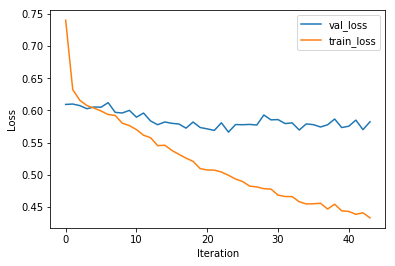

In [0]:
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='val_loss')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='train_loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration');

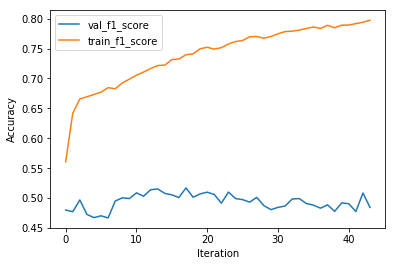

In [0]:
plt.plot(range(len(history.history['cust_f1_score'])), history.history['val_cust_f1_score'], label='val_f1_score')
plt.plot(range(len(history.history['cust_f1_score'])), history.history['cust_f1_score'], label='train_f1_score')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Iteration');

# Training with Train dataset

Training Data: (17521, 2395)
Test Data: (20442, 2394)

# of Columns with missing values greater than 70% --> 193

Dropping Columns with a lot of missing values...
(17521, 2202)
% of columns retained --> 91.94
dict_keys(['float64', 'int64'])
653 1547
# of Cols having null values and unique values < 400 ---> 79

Filling Cols with Mode...
# Null cols Before Filling --> 566
# Null cols After Filling --> 487

Filling Cols with Median...

Building PCA on entire dataset...
[1.68149163e-01 6.22980591e-02 5.13507537e-02 ... 7.58873818e-34
 7.58873818e-34 4.55389526e-34]


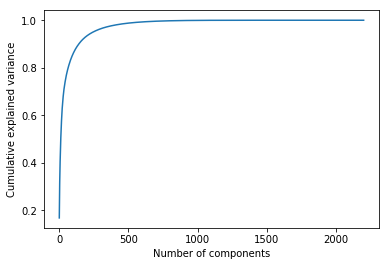

PCA Components with Explained Variance > 0.9 ---> 141

Applying ADASYN on Train Data...
Before Over Sampling -->
 0    15760
1     1761
Name: Col2, dtype: int64
After Over Sampling -->
 0    15760
1    15367
dtype: int64
Pre-processing Test Data...
X_Train: (31127, 141), Y_Train: (31127,), X_Test: (20442, 141)


In [0]:
# %%time

data_train = pd.read_csv('Train.csv', low_memory=False)
print("Training Data:", data_train.shape)
# data_train.head()

data_test = pd.read_csv('Test.csv', low_memory=False)
print("Test Data:", data_test.shape)
# data_test.head()

def data_pipe(data):
    cnt = 0
    cols_to_remove = []
    for i,j in zip(data.columns, data.isnull().sum()):
        missing_pct = round((j/data.shape[0]) * 100, 2)
        if missing_pct > 70:
            # print(f'{i} {j} --> {missing_pct}% data missing.')
            cnt += 1
            cols_to_remove.append(i)
    print(f'\n# of Columns with missing values greater than 70% --> {cnt}')

    print('\nDropping Columns with a lot of missing values...')
    data.drop(cols_to_remove, axis=1, inplace=True)
    print(data.shape)
    print(f'% of columns retained --> {round((data.shape[1]/2395) * 100, 2)}')

    cols = defaultdict(list)
    for i,j in zip(data.columns, data.dtypes):
        if i == 'Col1' or i == 'Col2':
            continue
        cols[str(j)].append(i)

    print(cols.keys())
    print(len(cols['float64']), len(cols['int64']))

    mode_cols = []
    for i in cols['float64']:
        nulls = data[i].isnull().sum()
        uniques = data[i].nunique()
        if nulls > 0:
            if uniques < 400:
                mode_cols.append(i)
            # print(i, "===>", uniques, "===>", nulls)
    print(f'# of Cols having null values and unique values < 400 ---> {len(mode_cols)}')

    print('\nFilling Cols with Mode...')
    cnt = 0
    for i in data.isnull().sum():
        if i > 0:
            cnt += 1
    print("# Null cols Before Filling -->", cnt)

    for i in mode_cols:
        data[i].fillna(value=data[i].mode().iloc[0], inplace=True)
        # print(i, data[i].mode().iloc[0])

    cnt = 0
    for i in data.isnull().sum():
        if i > 0:
            cnt += 1
    print("# Null cols After Filling -->", cnt)

    print('\nFilling Cols with Median...')
    data.fillna(value=data.median(), inplace=True)
    for i,j in zip(data.columns, data.isnull().sum()):
        if j > 0:
            print(i,j)

    print("\nBuilding PCA on entire dataset...")
    sc = StandardScaler()
    X = sc.fit_transform(data.drop(['Col1', 'Col2'], axis=1))

    pca = PCA(random_state=42)
    pca.fit(X)
    print(pca.explained_variance_ratio_)

    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show();

    for i,j in enumerate(pca.explained_variance_ratio_.cumsum()):
        if j > 0.90:
            print(f'PCA Components with Explained Variance > 0.9 ---> {i}')
            break

    X = sc.fit_transform(data.drop(['Col1', 'Col2'], axis=1))
    # X = data.drop(['Col1', 'Col2'], axis=1)

    pca = PCA(n_components=i, random_state=42)
    X_train = pca.fit_transform(X)
    y_train = data['Col2']

    # print("Train-Test Splitting...")
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("\nApplying ADASYN on Train Data...")
    sampler = ADASYN(random_state=42)
    print("Before Over Sampling -->\n", y_train.value_counts())
    X_train, y_train = sampler.fit_sample(X_train, y_train)
    print("After Over Sampling -->\n", pd.Series(y_train).value_counts())

    # print("Applying ROS on Test Data...")
    # sampler = RandomOverSampler(random_state=42)
    # print("Before Over Sampling -->\n", y_test.value_counts())
    # X_test, y_test = sampler.fit_sample(X_test, y_test)
    # print("After Over Sampling -->\n", pd.Series(y_test).value_counts())

    # sc = StandardScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.transform(X_test)

    print("="*100)
    print("Pre-processing Test Data...")
    # print("Test Drop")
    data_test.drop(cols_to_remove, axis=1, inplace=True)
    # print("Test Fill Mode")
    for i in mode_cols:
        data_test[i].fillna(value=data_test[i].mode().iloc[0], inplace=True)
    # print("Test Fill Median")
    data_test.fillna(value=data_test.median(), inplace=True)
    # print("Test SC Transform")
    X_test = sc.transform(data_test.drop(['Col1'], axis=1))
    # print("Test PCA Transform")
    X_test = pca.transform(X_test)

    print(f'X_Train: {X_train.shape}, Y_Train: {y_train.shape}, X_Test: {X_test.shape}')
    return (X_train, y_train, X_test)

X_train, y_train, X_test = data_pipe(data_train)

In [0]:
%%time

params = {'fit_intercept':[True, False],
          'penalty':['l2', 'l1'],
          'C':[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

lr = LogisticRegression(solver='saga', n_jobs=-1)
lr_model = RandomizedSearchCV(lr, param_distributions=params, n_iter=15, scoring='f1_macro', cv=4, verbose=True, random_state=42)
lr_model.fit(X_train, y_train)
y_hat = lr_model.predict(X_test)

pred_y = lr_model.predict(X_train)
print(lr_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, pred_y))
print()
print("Classification Report:\n", classification_report(y_train, pred_y))
print()
print("Confusion Matrix:\n", confusion_matrix(y_train, pred_y))

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

F1-Score (Train): 0.6617926890335503

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.70      0.69     15760
           1       0.68      0.65      0.66     15367

    accuracy                           0.67     31127
   macro avg       0.67      0.67      0.67     31127
weighted avg       0.67      0.67      0.67     31127


Confusion Matrix:
 [[11084  4676]
 [ 5455  9912]]
CPU times: user 10.6 s, sys: 6.84 s, total: 17.5 s
Wall time: 4min 46s


In [0]:
submission = pd.DataFrame()
submission['Col1'] = data_test['Col1']
submission['Col2'] = y_hat
print(submission.shape)
submission.head()

submission.to_csv('Submit_1.csv', index=False)

(20442, 2)


,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,1
4,RIYBGC1ZD,0


In [0]:
%%time

# d_train = lgb.Dataset(X_train, label=y_train)
parameters = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(50, 500),
             'max_depth': sp_randint(3, 25),
             'learning_rate': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
             'n_estimators': sp_randint(50, 125),
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
              }

lgbc = lgb.LGBMClassifier(random_state=42, objective='binary', metric='binary_logloss', silent=True)
lgb_model = RandomizedSearchCV(estimator=lgbc, param_distributions=parameters, n_iter=15, scoring='f1_macro', cv=4, refit=True, random_state=42, verbose=True, n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_hat = lgb_model.predict(X_test)

pred_y = lgb_model.predict(X_train)
print(lgb_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, pred_y))
print()
print("Classification Report:\n", classification_report(y_train, pred_y))
print()
print("Confusion Matrix:\n", confusion_matrix(y_train, pred_y))

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.6min finished


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7554487413172255, importance_type='split',
               learning_rate=1.0, max_depth=7, metric='binary_logloss',
               min_child_samples=356, min_child_weight=100.0,
               min_split_gain=0.0, n_estimators=70, n_jobs=-1, num_leaves=14,
               objective='binary', random_state=42, reg_alpha=10,
               reg_lambda=0.1, silent=True, subsample=0.9591084298026666,
               subsample_for_bin=200000, subsample_freq=0)

F1-Score (Train): 0.9092327860665459

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90     15760
           1       0.87      0.95      0.91     15367

    accuracy                           0.91     31127
   macro avg       0.91      0.91      0.91     31127
weighted avg       0.91      0.91      0.91     31127


Confusion Matrix:
 [[13654  2106]
 [  802 14565]]
CPU times: user

In [0]:
submission = pd.DataFrame()
submission['Col1'] = data_test['Col1']
submission['Col2'] = y_hat
print(submission.shape)
submission.to_csv('Submit_2.csv', index=False)

submission.head()

(20442, 2)


,Col1,Col2
0,RIGD58ZWD,1
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,1
4,RIYBGC1ZD,0


In [0]:
%%time

parameters = {'max_depth': sp_randint(3, 25),
              'learning_rate': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001, 0.0001],
              'n_estimators': sp_randint(50, 125),
              'reg_alpha': [100, 10, 1, 0, 0.1, 0.01, 1e-4],
              'reg_lambda': [100, 10, 1, 0, 0.1, 0.01, 1e-4],
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'colsample_bylevel': sp_uniform(loc=0.4, scale=0.6),
              'colsample_bynode': sp_uniform(loc=0.4, scale=0.6)
             }

xgb = XGBClassifier(n_jobs=-1)
xgb_model = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=15, scoring='f1_macro', cv=4, refit=True, verbose=True, random_state=42)
xgb_model.fit(X_train, y_train)
y_hat = xgb_model.predict(X_test)

pred_y = xgb_model.predict(X_train)
print(xgb_model.best_estimator_)
print()
print("F1-Score (Train):", f1_score(y_train, pred_y))
print()
print("Classification Report:\n", classification_report(y_train, pred_y))
print()
print("Confusion Matrix:\n", confusion_matrix(y_train, pred_y))

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 15.1min finished


XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8248435466776274,
              colsample_bynode=0.41235069657748147,
              colsample_bytree=0.9819459112971965, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=8, min_child_weight=0.001,
              missing=None, n_estimators=113, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6939852077021733, verbosity=1)

F1-Score (Train): 0.9642789880092911



NameError: ignored

In [0]:
submission = pd.DataFrame()
submission['Col1'] = data_test['Col1']
submission['Col2'] = y_hat
print(submission.shape)
submission.to_csv('Submit_3.csv', index=False)

submission.head()

(20442, 2)


,Col1,Col2
0,RIGD58ZWD,0
1,RIH660YDS,0
2,RIH660Q96,0
3,RIYDO15W1,1
4,RIYBGC1ZD,0
